Modeling: Mass Total + Source Inversion
=======================================

To fit a lens model to a dataset, we must perform lens modeling, which uses a `NonLinearSearch` to fit many
different tracers to the dataset.

In this example script, we fit `Imaging` of a strong lens system where:

 - The lens galaxy's light is omitted (and is not present in the simulated data).
 - The lens galaxy's total mass distribution is modeled as an `EllipticalIsothermal`.
 - The source galaxy's surface-brightness is modeled using an `Inversion`.

An `Inversion` reconstructs the source's light using a pixel-grid, which is regularized using a prior that forces
this reconstruction to be smooth. This uses `Pixelization` and `Regularization` objects and in this example we will
use their simplest forms, a `Rectangular` `Pixelization` and `Constant` `Regularization`.scheme.

Inversions are covered in detail in chapter 4 of the **HowToLens** lectures.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


Load the strong lens dataset `mass_sie__source_sersic` `from .fits files, which is the dataset we will
use to perform lens modeling.

This is the same dataset we fitted in the `autolens/intro/fitting.py` example.

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
    positions_path=path.join(dataset_path, "positions.json"),
)

The model-fit also requires a mask defining the regions of the image we fit the lens model to the data.

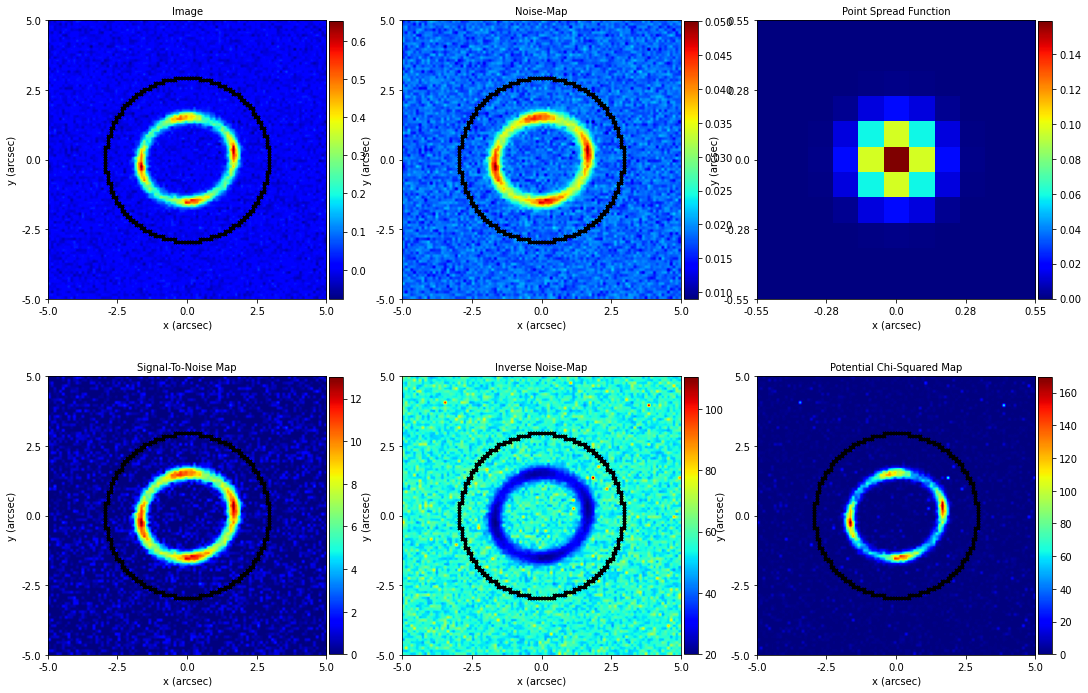

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Phase__

To perform lens modeling, we create a `PhaseImaging` object, which comprises:

   - The `GalaxyModel`'s used to fit the data.
   - The `SettingsPhase` which customize how the model is fitted to the data.
   - The `NonLinearSearch` used to sample parameter space.
   
Once we have create the phase, we `run` it by passing it the data and mask.

__Model__

We compose our lens model using `GalaxyModel` objects, which represent the galaxies we fit to our data. In this 
example our lens mooel is:

 - An `EllipticalIsothermal` `MassProfile`.for the lens galaxy's mass (5 parameters).
 - A `Rectangular` `Pixelization`.which reconstructs the source galaxy's light. We will fix its resolution to 
   30 x 30 pixels, which balances fast-run time with sufficient resolution to reconstruct its light. (0 parameters).
 - A `Constant` `Regularization`.scheme which imposes a smooothness prior on the source reconstruction (1 parameter). 

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=1. 
 
It is worth noting the `Pixelization` and `Regularization` use significantly fewer parameter (1 parameters) than 
fitting the source using `LightProfile`'s (7+ parameters). 

NOTE: By default, **PyAutoLens** assumes the image has been reduced such that the lens galaxy centre is at (0.0", 0.0"),
with the priors on the lens `MassProfile` coordinates set accordingly. if for your dataset the lens is not centred at 
(0.0", 0.0"), we recommend you reduce your data so it is (see `autolens_workspace/notebooks/preprocess`). 

Alternatively, you can manually override the priors (see `autolens_workspace/notebooks/imaging/modeling/customize/priors.py`).

In [4]:
lens = al.GalaxyModel(redshift=0.5, mass=al.mp.EllipticalIsothermal)
source = al.GalaxyModel(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(30, 30)),
    regularization=al.reg.Constant,
)

__Settings__

Next, we specify the `SettingsPhaseImaging`, which describe how the model is fitted to the data in the log likelihood
function. Below, we specify:
 
 - That a regular `Grid2D` is used to fit create the model-image when fitting the data 
      (see `autolens_workspace/examples/grids.py` for a description of grids).
 - The sub-grid size of this grid.

We specifically specify the grid that is used to perform the `Inversion`. In **PyAutoLens** it is possible to fit
data simultaneously with `LightProfile`'s and an `Inversion`. Each fit uses a different grid, which are specified 
independently.

`Inversion`'s suffer a problem where they reconstruct unphysical lens models, where the reconstructed soruce appears
as a demagnified reconstruction of the lensed source. These are covered in more detail in chapter 4 of **HowToLens**. 

To prevent these solutions impacting this fit we use position thresholding, which is describe fully in the 
script `autolens_workspace/notebooks/imaging/modeling/customize/positions.py`, Therefore, we also specify:

 - A positions_threshold of 0.5, meaning that the four (y,x) coordinates specified by our positions must trace
   within 0.5" of one another in the source-plane for a mass model to be accepted. If not, it is discarded and
   a new model is sampled.

The threshold of 0.5" is large. For an accurate lens model we would anticipate the positions trace within < 0.01" of
one another. However, we only want the threshold to aid the `NonLinearSearch` with the generation of the initial 
mass models. 

Different `SettingsPhase` are used in different example model scripts and a full description of all `SettingsPhase` 
can be found in the example script `autolens/workspace/notebooks/imaging/modeling/customize/settings.py` and the following 
chain -> <chain>

In [5]:
settings_masked_imaging = al.SettingsMaskedImaging(
    grid_inversion_class=al.Grid2D, sub_size=2, sub_size_inversion=4
)
settings_lens = al.SettingsLens(positions_threshold=0.5)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging, settings_lens=settings_lens
)

__Search__

The lens model is fitted to the data using a `NonLinearSearch`, which we specify below. In this example, we use the
nested sampling algorithm Dynesty (https://dynesty.readthedocs.io/en/latest/), with:

 - 50 live points.

The script `autolens_workspace/notebooks/imaging/modeling/customize/non_linear_searches.py` gives a description of the types of
non-linear searches that can be used with **PyAutoLens**. If you do not know what a `NonLinearSearch` is or how it 
operates, I recommend you complete chapters 1 and 2 of the HowToLens lecture series.

The `name` and `path_prefix` below specify the path where results are stored in the output folder:  

 `/autolens_workspace/output/imaging/mass_sie__source_sersic/phase_mass[sie]_source[inversion]`.

In [6]:
search = af.DynestyStatic(
    path_prefix=path.join("imaging", dataset_name),
    name="phase_mass[sie]_source[inversion]",
    n_live_points=50,
)

__Phase__

We can now combine the model, settings and search to create and run a phase, fitting our data with the lens model.

In [7]:
phase = al.PhaseImaging(
    search=search,
    galaxies=af.CollectionPriorModel(lens=lens, source=source),
    settings=settings,
)

We can now begin the fit by passing the dataset and mask to the phase, which will use the `NonLinearSearch` to fit
the model to the data. 

The fit outputs visualization on-the-fly, so checkout the path 
`autolens_workspace/output/examples/phase_mass[sie]_source[inversion]` to see how your fit is doing!

In [8]:
result = phase.run(dataset=imaging, mask=mask)

INFO:root:phase_mass[sie]_source[inversion] already completed, skipping non-linear search.


The phase above returned a result, which, for example, includes the lens model corresponding to the maximum
log likelihood solution in parameter space.

In [9]:
print(result.max_log_likelihood_instance)

It also contains instances of the maximum log likelihood Tracer and FitImaging, which can be used to visualize
the fit.

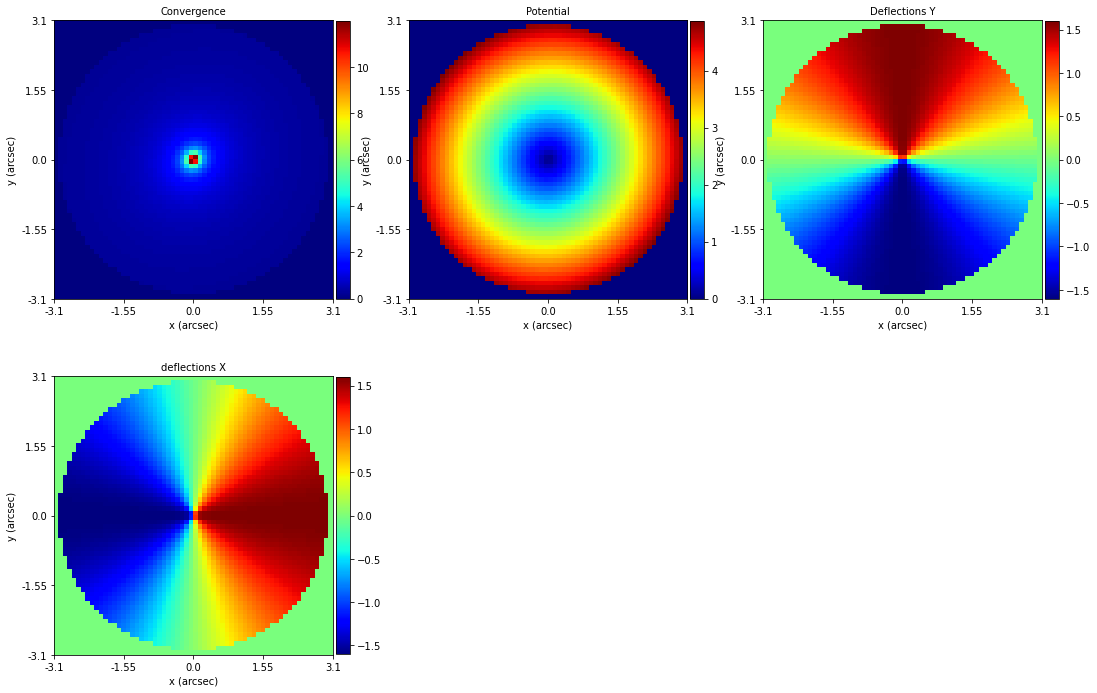

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'slim_indexes' of function 'furthest_grid_2d_slim_index_from'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../PyAutoArray/autoarray/structures/grids/two_d/grid_2d_util.py", line 673:
@decorator_util.jit()
def furthest_grid_2d_slim_index_from(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


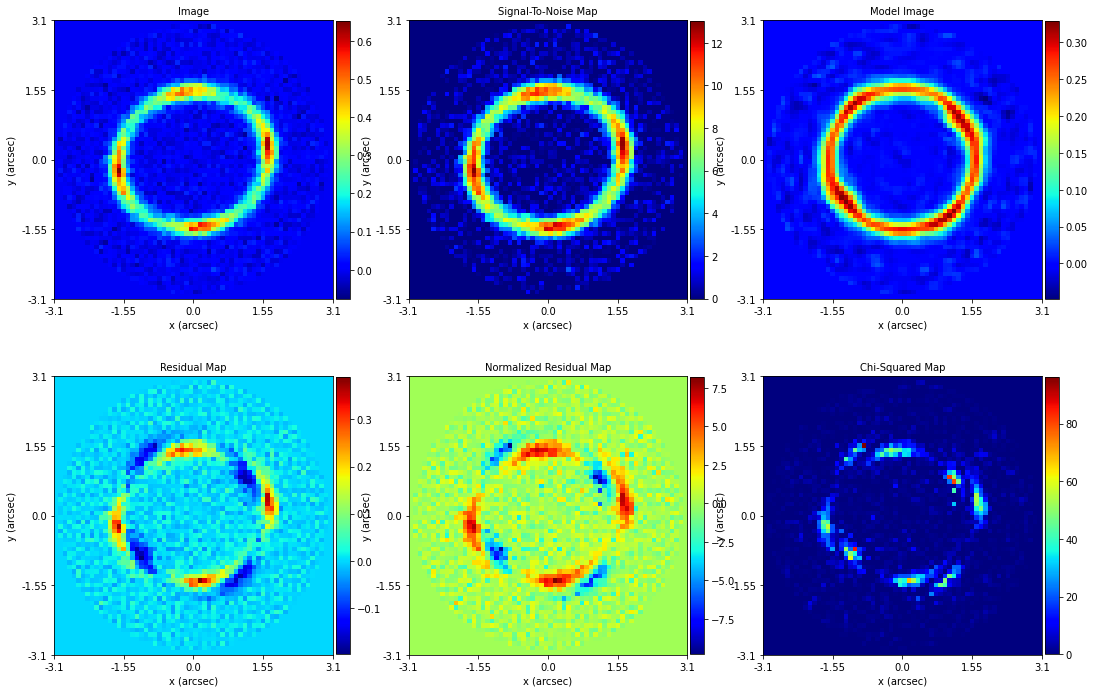

In [10]:
tracer_plotter = aplt.TracerPlotter(
    tracer=result.max_log_likelihood_tracer, grid=mask.masked_grid_sub_1
)
tracer_plotter.subplot_tracer()
fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

Checkout `autolens_workspace/notebooks/imaging/modeling/results.py` for a full description of the result object.